In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kendalltau
from cliffs_delta import cliffs_delta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="whitegrid", context='talk', palette='Greys')
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Distribution of the data

In [37]:
data = pd.read_csv("../data/bias_symptoms_logreg.csv", index_col=[0, 1])

In [38]:
def plot_differences(symps, symp, symp_name):
    corr_high_sp = symps[symps["statistical_parity"] == 1][symp].values
    corr_low_sp = symps[symps["statistical_parity"] == 0][symp].values
    corr_high_eo = symps[symps["equal_opportunity"] == 1][symp].values
    corr_low_eo = symps[symps["equal_opportunity"] == 0][symp].values
    corr_high_ao = symps[symps["average_odds"] == 1][symp].values
    corr_low_ao = symps[symps["average_odds"] == 0][symp].values
    df = pd.DataFrame(
        {
            symp_name: [
                corr_high_sp,
                corr_low_sp,
                corr_high_eo,
                corr_low_eo,
                corr_high_ao,
                corr_low_ao,
            ],
            "Metric": [
                "Statistical Parity",
                "Statistical Parity",
                "Equal Opportunity",
                "Equal Opportunity",
                "Average Odds",
                "Average Odds",
            ],
            "Bias": ["High", "Low", "High", "Low", "High", "Low"],
        }
    )
    df = df.explode(symp_name)
    g = sns.FacetGrid(df, col="Metric", height=4, aspect=1)
    g.map(
        sns.barplot,
        "Bias",
        symp_name,
        "Bias",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        palette=sns.color_palette()[1:4:2],
    )
    g.set_titles("{col_name}")
    g.add_legend()
    # g.facet_axis(0,0).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False)[1]))
    # g.facet_axis(0,1).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False)[1]))
    # g.facet_axis(0,2).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False)[1]))
    g.set_axis_labels("", symp_name)
    # plt.savefig(f"figs/{symp_name}.pdf", bbox_inches="tight")
    # plt.show()
    print(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False))
    print(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False))
    print(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False))
    print(cliffs_delta(corr_high_sp, corr_low_sp))
    print(cliffs_delta(corr_high_eo, corr_low_eo))
    print(cliffs_delta(corr_high_ao, corr_low_ao))
    return g

### Analysis of Mutual Information

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Ttest_indResult(statistic=12.763897120165879, pvalue=9.335723891740651e-37)
Ttest_indResult(statistic=4.667195753215789, pvalue=3.12428848262065e-06)
Ttest_indResult(statistic=8.866616825916202, pvalue=1.0075508669268701e-18)
(0.25144217240408967, 'small')
(0.13732781069296965, 'negligible')
(0.16519336575120425, 'small')


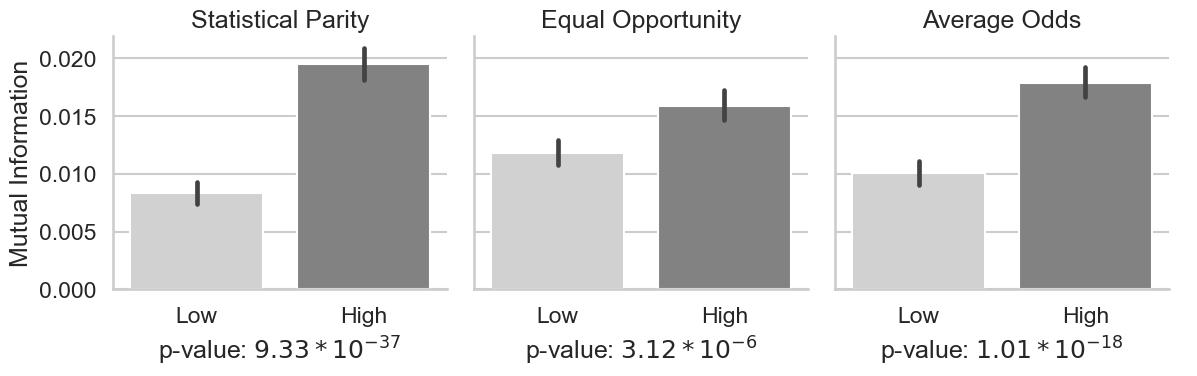

In [39]:
g = plot_differences(data, "mutual_info", "Mutual Information")
g.facet_axis(0, 0).set_xlabel(
    "p-value: $9.33*10^{-37}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 1).set_xlabel(
    "p-value: $3.12*10^{-6}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: $1.01*10^{-18}$", labelpad=5, fontdict={"fontsize": 18}
)
plt.savefig("figs/Mutual Information.pdf", bbox_inches="tight")
plt.show()

## Kendall's Tau

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Ttest_indResult(statistic=4.651459793604827, pvalue=3.3790804810504482e-06)
Ttest_indResult(statistic=0.4548176508959186, pvalue=0.6492573668242501)
Ttest_indResult(statistic=2.135171437841945, pvalue=0.0327928011184278)
(0.06837939390738224, 'negligible')
(-0.029787222887820285, 'negligible')
(0.028023423053215535, 'negligible')


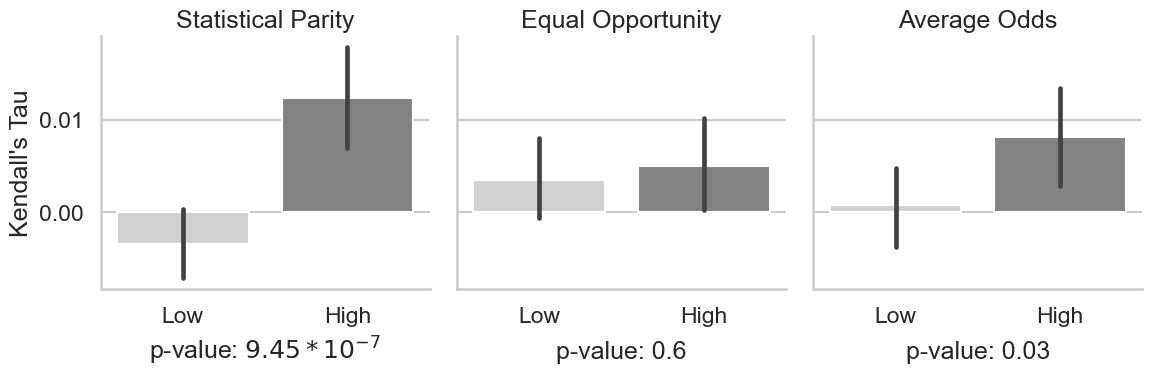

In [40]:
g = plot_differences(data, "correlation_true", "Kendall's Tau")

g.facet_axis(0,0).set_xlabel("p-value: $9.45*10^{-7}$", labelpad=5, fontdict={'fontsize': 18})
g.facet_axis(0, 1).set_xlabel(
    "p-value: 0.6", labelpad=10, fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: 0.03", labelpad=10, fontdict={"fontsize": 18}
)
plt.savefig("figs/Kendall's Tau.pdf", bbox_inches="tight")
plt.show()

## Metrics Distribution

In [41]:
distr = pd.DataFrame(
    [
        {
            "Statistical Parity": [
              data[data["statistical_parity"] == 0].shape[0]/data.shape[0],
              data[data["statistical_parity"] == 1].shape[0]/data.shape[0],
            ],
            "Equal Opportunity": [
              data[data["equal_opportunity"] == 0].shape[0]/data.shape[0],
              data[data["equal_opportunity"] == 1].shape[0]/data.shape[0],
            ],
            "Average Odds": [
              data[data["average_odds"] == 0].shape[0]/data.shape[0],
              data[data["average_odds"] == 1].shape[0]/data.shape[0],
            ],
            "Bias": ["Low", "High"]
        }
    ]
)

In [42]:
distr = distr.explode(['Statistical Parity', 'Equal Opportunity', 'Average Odds', 'Bias']).melt(id_vars='Bias', var_name='Metric', value_name='Percentage')

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_27946/2928899263.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


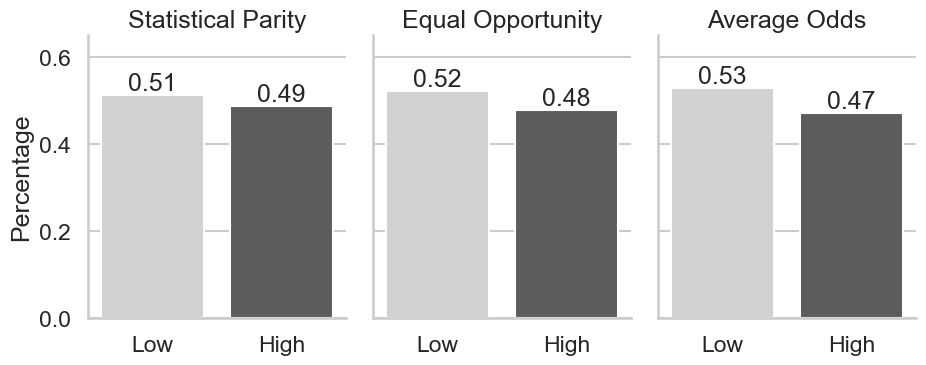

In [43]:
g = sns.catplot(
    data=distr,
    col="Metric",
    x="Bias",
    y="Percentage",
    kind="bar",
    hue="Bias",
    palette=sns.color_palette()[1:5:3],
    height=4,
    aspect=0.8,
)


for i in range(3):
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[0], fmt="%.2f")
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[1], fmt="%.2f")

g.set_titles("{col_name}")
# plt.subplots_adjust(top=1.3)
g.set_axis_labels("")
plt.ylim(0,0.65)
plt.tight_layout()
plt.savefig('metrics_distr.png', dpi=300, bbox_inches='tight')
plt.savefig("figs/metrics_distr.pdf", bbox_inches="tight")
plt.show()

## Distribution of SP, EO and AO

In [44]:
raw = pd.read_csv("../data/bias_symptoms_raw_logreg.csv", index_col=[0, 1])
metrics = raw[['statistical_parity', 'equal_opportunity', 'average_odds']]
metrics = pd.melt(metrics, var_name='Metric', value_name='Value')
metrics['Metric'] = metrics['Metric'].map({'statistical_parity': 'Statistical Parity', 'equal_opportunity': 'Equal Opportunity', 'average_odds': 'Average Odds'})
metrics['Value'] = metrics['Value'].abs()

In [45]:
raw[['statistical_parity', 'equal_opportunity', 'average_odds']].abs().describe()

,statistical_parity,equal_opportunity,average_odds
count,5930.000000,5893.000000,5930.000000
mean,0.223380,0.164061,0.212512
std,0.199799,0.190150,0.206985
min,0.000000,0.000000,0.000000
25%,0.039648,0.019323,0.021523
50%,0.196647,0.091837,0.129636
75%,0.369281,0.266667,0.357851
max,1.000000,0.999312,1.000000


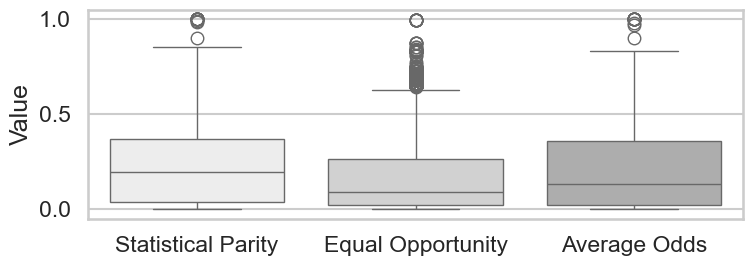

In [15]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(data=metrics, x='Metric', y='Value', hue='Metric')
plt.xlabel('')
plt.tight_layout()
plt.savefig('figs/metrics_boxplot.pdf', bbox_inches='tight')
plt.show()

## Distribution of unbalance between items with high and low SP

In [55]:
import os

high_sp = data[data['statistical_parity'] == 1]
high_sp

correlation_true   mutual_info  unpriv_prob_pos  \
variable          data                                                          
23                arrhythmia          0.071520  7.555464e-02         0.454545   
24                arrhythmia          0.152653  4.232343e-02         0.444444   
26                arrhythmia          0.021056  5.583373e-02         0.444444   
38                arrhythmia          0.110542  1.047324e-01         0.444444   
46                arrhythmia          0.046635  1.995765e-01         0.465116   
...                                        ...           ...              ...   
PerformanceRating ibm                -0.018166  1.681345e-04         0.000000   
                  ibm                -0.080231  3.520686e-03         0.000000   
                  ibm                -0.093194  5.311554e-03         0.000000   
                  ibm                -0.000338  5.719265e-08         0.000000   
                  ibm                 0.096484  4.275073e-03         0.000000   

                              priv_prob_pos  unpriv_unbalance  priv_unbalance  \
variable          data                                                          
23                arrhythmia       0.000000          1.045455             0.0   
24                arrhythmia       0.000000          1.022222             0.0   
26                arrhythmia       0.000000          1.022222             0.0   
38                arrhythmia       0.000000          1.022222             0.0   
46                arrhythmia       0.000000          1.069767             0.0   
...                                     ...               ...             ...   
PerformanceRating ibm              0.809524          0.000000             1.0   
                  ibm              0.802721          0.000000             1.0   
                  ibm              0.877551          0.000000             1.0   
                  ibm              0.789116          0.000000             1.0   
                  ibm              0.816327          0.000000             1.0   

                              statistical_parity  equal_opportunity  \
variable          data                                                
23                arrhythmia                 1.0                1.0   
24                arrhythmia                 1.0                1.0   
26                arrhythmia                 1.0                1.0   
38                arrhythmia                 1.0                1.0   
46                arrhythmia                 1.0                0.0   
...                                          ...                ...   
PerformanceRating ibm                        1.0                0.0   
                  ibm                        1.0                0.0   
                  ibm                        1.0                0.0   
                  ibm                        1.0                0.0   
                  ibm                        1.0                0.0   

                              average_odds  kurtosis_var  skew_var      gini  \
variable          data                                                         
23                arrhythmia           1.0     20.315083  4.629568  0.110091   
24                arrhythmia           1.0     46.000000  6.782330  0.111328   
26                arrhythmia           1.0     46.000000  6.782330  0.111328   
38                arrhythmia           1.0     46.000000  6.782330  0.111328   
46                arrhythmia           1.0     11.771965  3.641645  0.108854   
...                                    ...           ...       ...       ...   
PerformanceRating ibm                  1.0      1.673718  1.910793  0.058043   
                  ibm                  1.0      1.408103  1.840959  0.058122   
                  ibm                  1.0      2.284163  2.062346  0.057881   
                  ibm                  1.0      3.027831  2.233119  0.057711   
                  ibm                 

## REDUN Algorithm

In [20]:
%%R -i data
library(tidyverse)
library(Hmisc)


data <- data %>% select(-data, -variable)
m <- redun(as.matrix(data, r2 = 0.8, nk = 0))
reducedData <- m$In
data <- data[, reducedData]
data %>% colnames()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
 [1] "correlation_true"   "mutual_info"        "unpriv_prob_pos"   
 [4] "unpriv_unbalance"   "priv_unbalance"     "statistical_parity"
 [7] "equal_opportunity"  "average_odds"       "skew_var"          
[10] "gini"               "simpson"            "shannon"           
[13] "ir"                 "pos_prob"          



Caricamento pacchetto: ‘Hmisc’

I seguenti oggetti sono mascherati da ‘package:dplyr’:

    src, summarize

I seguenti oggetti sono mascherati da ‘package:base’:

    format.pval, units



In [21]:
data_new = data[
    [
      "data", "variable",
        "correlation_true",
        "mutual_info",
        "unpriv_prob_pos",
        "unpriv_unbalance",
        "priv_unbalance",
        "statistical_parity",
        "equal_opportunity",
        "average_odds",
        "skew_var",
        "gini",
        "simpson",
        "shannon",
        "ir",
        "pos_prob"
    ]
]

In [22]:
data_new.columns

Index(['data', 'variable', 'correlation_true', 'mutual_info',
       'unpriv_prob_pos', 'unpriv_unbalance', 'priv_unbalance',
       'statistical_parity', 'equal_opportunity', 'average_odds', 'skew_var',
       'gini', 'simpson', 'shannon', 'ir', 'pos_prob'],
      dtype='object')

In [23]:
data.columns

Index(['variable', 'data', 'correlation_true', 'mutual_info',
       'unpriv_prob_pos', 'priv_prob_pos', 'unpriv_unbalance',
       'priv_unbalance', 'statistical_parity', 'equal_opportunity',
       'average_odds', 'kurtosis_var', 'skew_var', 'gini', 'simpson',
       'shannon', 'ir', 'pos_prob'],
      dtype='object')

In [24]:
data_new.to_csv("../data/bias_symptoms_logreg_reduced.csv", index=False)

## Correlation analysis

In [28]:
raw = raw.reset_index()

In [29]:
raw_new = raw[
    [
        "data",
        "variable",
        "correlation_true",
        "mutual_info",
        "unpriv_prob_pos",
        "unpriv_unbalance",
        "priv_unbalance",
        "statistical_parity",
        "equal_opportunity",
        "average_odds",
        "skew_var",
        "gini",
        "simpson",
        "shannon",
        "ir",
        "pos_prob",
    ]
]

In [30]:
raw_new

,data,variable,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,statistical_parity,equal_opportunity,average_odds,skew_var,gini,simpson,shannon,ir,pos_prob
0,arrhythmia,1,-0.329830,0.263048,0.250000,0.575000,1.326923,-0.165385,0.003846,0.051515,-0.272071,0.080404,0.029740,0.999956,0.769208,0.326923
1,arrhythmia,23,0.071520,0.075555,0.454545,1.045455,0.000000,0.568182,0.363636,0.591667,4.629568,0.110091,0.016495,0.999949,0.045361,0.454545
2,arrhythmia,24,0.152653,0.042323,0.444444,1.022222,0.000000,0.555556,0.355556,0.585000,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444
3,arrhythmia,26,0.021056,0.055834,0.444444,1.022222,0.000000,0.555556,0.355556,0.585000,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444
4,arrhythmia,38,0.110542,0.104732,0.444444,1.022222,0.000000,0.555556,0.355556,0.585000,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5925,ibm,MaritalStatus_Divorced,-0.095871,0.005095,0.798319,0.977941,1.093750,0.000000,0.094538,0.000000,1.592781,0.101727,0.002141,0.999786,0.235219,0.094538
5926,ibm,MaritalStatus_Married,-0.058910,0.001746,0.794872,0.973718,1.029710,0.000000,0.045708,0.000000,0.123947,0.085857,0.002951,0.999796,0.884604,0.045708
5927,ibm,MaritalStatus_Single,0.141521,0.009645,0.855670,1.048196,0.906500,0.000000,-0.115670,0.000000,0.681858,0.093211,0.002687,0.999794,0.515416,0.115670
5928,ibm,OverTime_No,-0.306588,0.044253,0.645833,0.791146,1.101263,0.000000,0.253157,0.000000,-0.747479,0.074244,0.002644,0.999793,0.484798,0.253157


In [31]:
sp = raw_new.pop('statistical_parity').abs()
eo = raw_new.pop("equal_opportunity").abs()
ao = raw_new.pop("average_odds").abs()

raw_new.insert(len(raw_new.columns), "statistical_parity", sp)
raw_new.insert(len(raw_new.columns), "equal_opportunity", eo)
raw_new.insert(len(raw_new.columns), "average_odds", ao)

In [32]:
kendall = raw_new.drop(columns=['variable', 'data']).corr("spearman").round(3)
for col in kendall.columns:
    for col2 in kendall.columns:
        pval = kendalltau(data[col], data[col2])[1]
        if np.abs(kendall.loc[col, col2]) > 0.95:
            kendall.loc[col, col2] = r"\cellcolor{black!25}\textbf{" + str(kendall.loc[col, col2]) + "}"
        if pval > 0.05:
            kendall.loc[col, col2] = f"{kendall.loc[col, col2]}*"

In [33]:
upper = kendall.where(np.triu(np.ones(kendall.shape), k=1).astype(bool))

In [34]:
upper

,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,skew_var,gini,simpson,shannon,ir,pos_prob,statistical_parity,equal_opportunity,average_odds
correlation_true,NaN,0.047*,0.021,-0.077,-0.104,0.027*,0.029*,0.041,0.04,0.002*,0.07,0.069,-0.008,0.039*
mutual_info,NaN,NaN,0.207,0.123,-0.021*,-0.391,-0.391,0.38,0.375,0.414,0.46,0.264,0.144,0.181
unpriv_prob_pos,NaN,NaN,NaN,0.184,0.02*,-0.081,-0.073,0.783,0.782,0.181,0.141,0.095,0.301,0.006
unpriv_unbalance,NaN,NaN,NaN,NaN,-0.687,0.035*,0.046*,0.041,0.041,0.068,0.0*,-0.009*,-0.014*,0.051
priv_unbalance,NaN,NaN,NaN,NaN,NaN,-0.162,-0.163,0.141,0.141,0.149,-0.106,-0.068,0.029*,-0.266
skew_var,NaN,NaN,NaN,NaN,NaN,NaN,\cellcolor{black!25}\textbf{0.994},-0.333,-0.327,-0.877,0.4,0.378,0.387,0.302
gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.337,-0.331,-0.872,0.385,0.362,0.384,0.29
simpson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\cellcolor{black!25}\textbf{0.999},0.412,0.1,0.102*,0.306,-0.053
shannon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405,0.102,0.104*,0.308,-0.05
ir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.458,-0.432,-0.412,-0.389


In [35]:
upper.to_latex('full_corr.tex', float_format="%.3f", escape=False, na_rep="-")